# Setup

In [ ]:
import tensorflow as tf
import os
import json
import pandas as pd
import re
import numpy as np
import time
import matplotlib.pyplot as plt
import collections
import random
import requests
from math import sqrt
from PIL import Image
from tqdm.auto import tqdm

In [ ]:
tf.config.run_functions_eagerly(True)

# Data Preparation

In [ ]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
import zipfile

# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

# Check if the data folder exists in your Google Drive
if not os.path.exists('/content/gdrive/MyDrive/Images/Final_image_dataset_ML_reduced_size_orientation_adjusted/Images') or not os.path.exists('/content/gdrive/MyDrive/Images/Final_image_dataset_ML_reduced_size_orientation_adjusted/image_captions_removed_commas_new_modified.txt'):
    print("Error: Data folder or captions file not found in Google Drive.")
else:
    # Copy images from Google Drive
    source_images_path = '/content/gdrive/MyDrive/Images/Final_image_dataset_ML_reduced_size_orientation_adjusted/Images'
    destination_images_path = '/content/data/Images'
    os.makedirs(destination_images_path, exist_ok=True)
    os.system(f'cp -r {source_images_path}/* {destination_images_path}/')

    # Copy captions file from Google Drive
    source_captions_path = '/content/gdrive/MyDrive/Images/Final_image_dataset_ML_reduced_size_orientation_adjusted/image_captions_removed_commas_new_modified.txt'
    destination_captions_path = '/content/data/captions.txt'
    os.system(f'cp {source_captions_path} {destination_captions_path}')


Mounted at /content/gdrive


In [ ]:
captions = pd.read_csv('/content/data/captions.txt')
captions['image'] = captions['image'].apply(
    lambda x: f'/content/data/Images/{x}')
captions.head()

,image,caption
0,/content/data/Images/Copy_of_20231102_153052.jpg,Two men standing on the edge of the platform.
1,/content/data/Images/Copy_of_20231102_153052.jpg,Two individuals standing at the platform's edge.
2,/content/data/Images/Copy_of_20231102_153052.jpg,On the platform's edge two men stand side by s...
3,/content/data/Images/Copy_of_20231102_153052.jpg,At the edge of the platform there are two men ...
4,/content/data/Images/Copy_of_20231102_153052.jpg,Two gentlemen stand together positioned on the...


# Preprocessing Captions

In [ ]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip()
    text = '[start] ' + text + ' [end]'
    return text

In [ ]:
captions['caption'] = captions['caption'].apply(preprocess)
captions.head()

,image,caption
0,/content/data/Images/Copy_of_20231102_153052.jpg,[start] two men standing on the edge of the pl...
1,/content/data/Images/Copy_of_20231102_153052.jpg,[start] two individuals standing at the platfo...
2,/content/data/Images/Copy_of_20231102_153052.jpg,[start] on the platforms edge two men stand si...
3,/content/data/Images/Copy_of_20231102_153052.jpg,[start] at the edge of the platform there are ...
4,/content/data/Images/Copy_of_20231102_153052.jpg,[start] two gentlemen stand together positione...


# EDA

[start] be cautious of the yellow safety line on the platform [end]



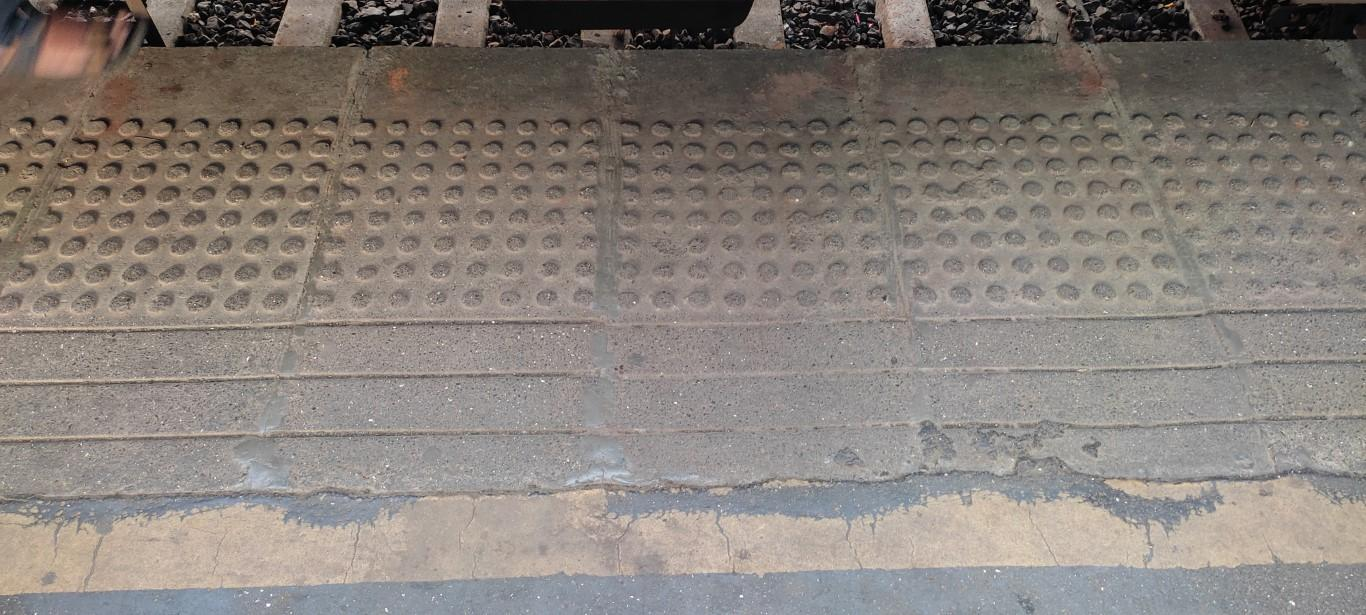

In [ ]:
random_row = captions.sample(1).iloc[0]
print(random_row.caption)
print()
im = Image.open(random_row.image)
im

In [ ]:
MAX_LENGTH = 40   # the model will consider max 40 words for understanding the meaning of a sent
VOCABULARY_SIZE = 10000
BATCH_SIZE = 32
BUFFER_SIZE = 1000
EMBEDDING_DIM = 512   # each word will be represented by a dense vector of length 512
UNITS = 512 # Dimensionality of the output space of certain layers

In [ ]:
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCABULARY_SIZE,
    standardize=None,
    output_sequence_length=MAX_LENGTH)

tokenizer.adapt(captions['caption'])

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [ ]:
word2idx = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())

idx2word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [ ]:
word2idx_table = word2idx.get_vocabulary()
idx2word_table = idx2word.get_vocabulary()


In [ ]:
print(word2idx_table)

['', '[UNK]', 'the', '[start]', '[end]', 'platform', 'edge', 'on', 'is', 'of', 'a', 'train', 'with', 'visible', 'and', 'people', 'in', 'be', 'line', 'yellow', 'are', 'caution', 'safety', 'bridge', 'detected', 'ahead', 'divyangjan', 'exercise', 'to', 'stairs', 'compartment', 'cautious', 'care', 'railway', 'opposite', 'careful', 'platforms', 'individuals', 'entrance', 'view', 'stationary', 'front', 'door', 'standing', 'seen', 'warning', 'can', 'its', 'scene', 'signboard', 'moving', 'inside', 'boundary', 'as', 'no', 'left', 'watch', 'passengers', 'halted', 'at', 'you', 'walking', 'clearly', 'clear', 'both', 'stairways', 'from', 'out', 'commuters', 'few', 'displayed', 'approaching', 'right', 'overhead', 'up', 'tracks', 'motion', 'captured', 'your', 'still', 'side', 'present', 'down', 'stands', 'nearby', 'empty', 'vigilant', 'that', 'stationery', 'prominently', 'mind', 'an', 'trains', 'occupied', 'currently', 'by', 'busy', 'above', 'while', 'stationed', 'stand', 'moment', 'indication', 'des

In [ ]:
print(idx2word_table)

['', '[UNK]', 'the', '[start]', '[end]', 'platform', 'edge', 'on', 'is', 'of', 'a', 'train', 'with', 'visible', 'and', 'people', 'in', 'be', 'line', 'yellow', 'are', 'caution', 'safety', 'bridge', 'detected', 'ahead', 'divyangjan', 'exercise', 'to', 'stairs', 'compartment', 'cautious', 'care', 'railway', 'opposite', 'careful', 'platforms', 'individuals', 'entrance', 'view', 'stationary', 'front', 'door', 'standing', 'seen', 'warning', 'can', 'its', 'scene', 'signboard', 'moving', 'inside', 'boundary', 'as', 'no', 'left', 'watch', 'passengers', 'halted', 'at', 'you', 'walking', 'clearly', 'clear', 'both', 'stairways', 'from', 'out', 'commuters', 'few', 'displayed', 'approaching', 'right', 'overhead', 'up', 'tracks', 'motion', 'captured', 'your', 'still', 'side', 'present', 'down', 'stands', 'nearby', 'empty', 'vigilant', 'that', 'stationery', 'prominently', 'mind', 'an', 'trains', 'occupied', 'currently', 'by', 'busy', 'above', 'while', 'stationed', 'stand', 'moment', 'indication', 'des

In [ ]:
print(idx2word)

In [ ]:
vocabulary = tokenizer.get_vocabulary()

with open('vocabulary.txt', 'w') as f:
    for item in vocabulary:
        f.write("%s\n" % item)



# Dataset Splitting

In [ ]:
# creating a defaultdict to store image paths as keys and their corresponding captions as values
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(captions['image'], captions['caption']):
    img_to_cap_vector[img].append(cap)


# shuffling and then splitting into training and validation
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = (img_keys[:slice_index],
                                          img_keys[slice_index:])


# For each caption of the img, store it with the img path

train_imgs = []
train_captions = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    train_imgs.extend([imgt] * capt_len)
    train_captions.extend(img_to_cap_vector[imgt])

val_imgs = []
val_captions = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    val_imgs.extend([imgv] * capv_len)
    val_captions.extend(img_to_cap_vector[imgv])

In [ ]:
for i, (val_img, val_caption) in enumerate(zip(val_imgs, val_captions)):
    print("Index:", i)
    print("Image:", val_img)
    print("Caption:", val_caption)


Index: 0
Image: /content/data/Images/Copy_of_IMG_20231013_165939.jpg
Caption: [start] warning approach with caution platform edge ahead [end]
Index: 1
Image: /content/data/Images/Copy_of_IMG_20231013_165939.jpg
Caption: [start] caution platform edge approaching be careful [end]
Index: 2
Image: /content/data/Images/Copy_of_IMG_20231013_165939.jpg
Caption: [start] be careful platform edge is just ahead [end]
Index: 3
Image: /content/data/Images/Copy_of_IMG_20231013_165939.jpg
Caption: [start] alert approach with caution platform edge ahead [end]
Index: 4
Image: /content/data/Images/Copy_of_IMG_20231013_165939.jpg
Caption: [start] exercise caution platform edge is approaching be vigilant [end]
Index: 5
Image: /content/data/Images/Copy_of_IMG_20231027_164533601.jpg
Caption: [start] be careful platform edge in front [end]
Index: 6
Image: /content/data/Images/Copy_of_IMG_20231027_164533601.jpg
Caption: [start] caution platform edge is in frontbe careful [end]
Index: 7
Image: /content/data/Im

* Train imgs: 108
* Val imgs: 28
* Total: 136
* *5 since 5 captions for each

In [ ]:
len(train_imgs), len(train_captions), len(val_imgs), len(val_captions)

(540, 540, 140, 140)

In [ ]:
# loading and preprocessing an image along with its corresponding caption, ensuring validity and normalization of the image while tokenizing the caption

def load_data(img_path, caption):
    try:
      img = tf.io.read_file(img_path)
      img = tf.image.decode_jpeg(img, channels=3)
    except tf.errors.InvalidArgumentError:
        # Try decoding as jpg
        try:
            img = tf.io.decode_jpg(img, channels=3)
        except tf.errors.InvalidArgumentError as e:
            print(f"Error decoding image: {img_path}")
            print(f"Exception details: {e}")
            return None, None

    # If the image shape does not have three dimensions
    if img.shape.ndims != 3:
        print(f"Invalid image dimensions for image: {img_path}")
        return None, None

    # resizing and normalizing
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = img / 255.
    caption = tokenizer(caption)
    return img, caption


In [ ]:
# checking for loading issues

# import cv2
# import os

# data_path = "/content/data/Images"

# for filename in os.listdir(data_path):
#     filepath = os.path.join(data_path, filename)
#     try:
#         img = cv2.imread(filepath)
#         if img is None:
#             print(f"Error loading image: {filepath}")
#         else:
#             print(f"Image loaded successfully: {filepath}")
#     except Exception as e:
#         print(f"Error processing image: {filepath}")
#         print(f"Exception details: {e}")


checking image size

In [ ]:
# import os

# data_path = "/content/data/Images"

# for filename in os.listdir(data_path):
#     filepath = os.path.join(data_path, filename)
#     size = os.path.getsize(filepath)
#     print(f"File: {filename}, Size: {size} bytes")


In [ ]:
# creating TensorFlow datasets from the prev split

train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_imgs, train_captions))

train_dataset = train_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_imgs, val_captions))

val_dataset = val_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
print(val_imgs)
print(len(val_captions))
print(val_dataset)

['/content/data/Images/Copy_of_IMG_20231013_165939.jpg', '/content/data/Images/Copy_of_IMG_20231013_165939.jpg', '/content/data/Images/Copy_of_IMG_20231013_165939.jpg', '/content/data/Images/Copy_of_IMG_20231013_165939.jpg', '/content/data/Images/Copy_of_IMG_20231013_165939.jpg', '/content/data/Images/Copy_of_IMG_20231027_164533601.jpg', '/content/data/Images/Copy_of_IMG_20231027_164533601.jpg', '/content/data/Images/Copy_of_IMG_20231027_164533601.jpg', '/content/data/Images/Copy_of_IMG_20231027_164533601.jpg', '/content/data/Images/Copy_of_IMG_20231027_164533601.jpg', '/content/data/Images/Copy_of_IMG_20231027_164512274.jpg', '/content/data/Images/Copy_of_IMG_20231027_164512274.jpg', '/content/data/Images/Copy_of_IMG_20231027_164512274.jpg', '/content/data/Images/Copy_of_IMG_20231027_164512274.jpg', '/content/data/Images/Copy_of_IMG_20231027_164512274.jpg', '/content/data/Images/Copy_of_20231102_155627.jpg', '/content/data/Images/Copy_of_20231102_155627.jpg', '/content/data/Images/Cop

In [ ]:
# augmentation layer

image_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomContrast(0.3),
    ]
)

# Building the model

In [ ]:
def CNN_Encoder():
    inception_v3 = tf.keras.applications.InceptionV3(
        include_top=False,  # not including the fully connected layer
        weights='imagenet'
    )
    inception_v3.trainable = False  # freezing the weights
    # only the layers on top of it will be trained

    output = inception_v3.output  # output tensor (feature output) of inception  v3
    output = tf.keras.layers.Reshape(
        (-1, output.shape[-1]))(output)   # resizing hte output tensor to: batch_size=-1
        # output.shape[-1]: the no. of features (which is fixed)

    cnn_model = tf.keras.models.Model(inception_v3.input, output)
    return cnn_model

In [ ]:
# encoder layer of transformer


class TransformerEncoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, num_heads): # 512, 1
        super().__init__()
        self.layer_norm_1 = tf.keras.layers.LayerNormalization()
        self.layer_norm_2 = tf.keras.layers.LayerNormalization()  # to normalize o/p of each layer

        self.attention = tf.keras.layers.MultiHeadAttention(    # to learn long-range dependencies
            num_heads=num_heads, key_dim=embed_dim)
        self.dense = tf.keras.layers.Dense(embed_dim, activation="relu")  # fully connected n/w


    def call(self, x, training):
        x = self.layer_norm_1(x)
        x = self.dense(x)

        attn_output = self.attention(
            # query, key, val vectors:
            query=x,
            value=x,
            key=x,

            attention_mask=None,
            training=training
        )

        x = self.layer_norm_2(x + attn_output)
        return x

In [ ]:
# word + positional embedding - to provide information about the position of words order in seq(caption)

class Embeddings(tf.keras.layers.Layer):

    def __init__(self, vocab_size, embed_dim, max_len):   # takes 3 i/p: size of vocab; vector size of each word (512); max words to consider in order to understand the meaning of a caption
        super().__init__()
        self.token_embeddings = tf.keras.layers.Embedding(
            vocab_size, embed_dim)    # for generating embeddings for each word
        self.position_embeddings = tf.keras.layers.Embedding(
            max_len, embed_dim, input_shape=(None, max_len))


    def call(self, input_ids):  # input seq
        length = tf.shape(input_ids)[-1]
        position_ids = tf.range(start=0, limit=length, delta=1)
        position_ids = tf.expand_dims(position_ids, axis=0)

        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)

        return token_embeddings + position_embeddings

In [ ]:
Embeddings(tokenizer.vocabulary_size(), EMBEDDING_DIM, MAX_LENGTH)(next(iter(train_dataset))[1]).shape

TensorShape([32, 40, 512])

In [ ]:
class TransformerDecoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, units, num_heads):
        super().__init__()
        self.embedding = Embeddings(
            tokenizer.vocabulary_size(), embed_dim, MAX_LENGTH)

        self.attention_1 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )

        self.layernorm_1 = tf.keras.layers.LayerNormalization()   # help stabilize the learning process
        self.layernorm_2 = tf.keras.layers.LayerNormalization()
        self.layernorm_3 = tf.keras.layers.LayerNormalization()

        self.ffn_layer_1 = tf.keras.layers.Dense(units, activation="relu")  # feed foward layer
        self.ffn_layer_2 = tf.keras.layers.Dense(embed_dim)

        self.out = tf.keras.layers.Dense(tokenizer.vocabulary_size(), activation="softmax")   # op layer

        self.dropout_1 = tf.keras.layers.Dropout(0.3)
        self.dropout_2 = tf.keras.layers.Dropout(0.5)


    def call(self, input_ids, encoder_output, training, mask=None):     # this method checks if training = true
        embeddings = self.embedding(input_ids)

        combined_mask = None
        padding_mask = None

        if mask is not None:
            causal_mask = self.get_causal_attention_mask(embeddings)
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attn_output_1 = self.attention_1(
            query=embeddings,
            value=embeddings,
            key=embeddings,
            attention_mask=combined_mask,
            training=training
        )

        out_1 = self.layernorm_1(embeddings + attn_output_1)

        attn_output_2 = self.attention_2(
            query=out_1,
            value=encoder_output,
            key=encoder_output,
            attention_mask=padding_mask,
            training=training
        )

        out_2 = self.layernorm_2(out_1 + attn_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds


    def get_causal_attention_mask(self, inputs):    # each token can only attend to previous tokens or itself
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0
        )
        return tf.tile(mask, mult)

In [ ]:
class EagerIdx2Word(tf.keras.layers.Layer):
    def __init__(self, idx2word_layer):
        super(EagerIdx2Word, self).__init__()
        self.idx2word_layer = idx2word_layer

    def call(self, inputs):
        # Convert symbolic tensor to concrete values
        concrete_inputs = tf.keras.backend.eval(inputs)
        # Perform the lookup using the original idx2word layer
        return self.idx2word_layer(concrete_inputs)

In [ ]:
class ImageCaptioningModel(tf.keras.Model):

    def __init__(self, cnn_model, encoder, decoder, image_aug=None):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.image_aug = image_aug
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker = tf.keras.metrics.Mean(name="accuracy")
        self.eager_idx2word = EagerIdx2Word(idx2word)  # Create the wrapper layer



    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)


    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)


    def compute_loss_and_acc(self, img_embed, captions, training=True):   # processes the entire caption sequence in one go, predicting the next word for each position simultaneously
        encoder_output = self.encoder(img_embed, training=True)   # encoder - captures context reln within the img
        y_input = captions[:, :-1]
        y_true = captions[:, 1:]    # excluding [start] token
        mask = (y_true != 0)
        y_pred = self.decoder(    # decoder
            y_input, encoder_output, training=True, mask=mask
        )
        loss = self.calculate_loss(y_true, y_pred, mask)
        acc = self.calculate_accuracy(y_true, y_pred, mask)
        return loss, acc


    def train_step(self, batch):    # called during training - it defines the training process
        imgs, captions = batch

        if self.image_aug:
            imgs = self.image_aug(imgs)

        img_embed = self.cnn_model(imgs)    # the imgs are passed thrg the cnn encoder - it creates an img embedding

        with tf.GradientTape() as tape:
            loss, acc = self.compute_loss_and_acc(    # this func calls encoder and decoder
                img_embed, captions
            )

        train_vars = (
            self.encoder.trainable_variables + self.decoder.trainable_variables
        )
        grads = tape.gradient(loss, train_vars)
        self.optimizer.apply_gradients(zip(grads, train_vars))
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}


    def test_step(self, batch):
        imgs, captions = batch

        img_embed = self.cnn_model(imgs)

        loss, acc = self.compute_loss_and_acc(
            img_embed, captions, training=False
        )

        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]


    # def call(self, inputs, training=None, mask=None):
    #     img_embed = self.cnn_model(inputs)
    #     encoder_output = self.encoder(img_embed, training=True)
    #     # You might need to adapt the following lines based on your model structure
    #     y_input = tf.zeros((1, MAX_LENGTH - 1), dtype=tf.int32)
    #     y_pred = self.decoder(y_input, encoder_output, training=True, mask=None)
    #     return y_pred



    @tf.function  # Decorate to create a TensorFlow graph
    def call(self, img):
        img = tf.expand_dims(img, axis=0)  # Add batch dimension
        img_embed = self.cnn_model(img)
        img_encoded = self.encoder(img_embed, training=False)

        y_inp = tf.constant('[start]')  # Initialize as a TensorFlow tensor

        for i in tf.range(MAX_LENGTH - 1):  # Use tf.range for loop control
            tokenized = tokenizer([y_inp])[:, :-1]
            mask = tf.cast(tokenized != 0, tf.int32)
            pred = self.decoder(
                tokenized, img_encoded, training=False, mask=mask)

            pred_idx = tf.argmax(pred[0, i, :], axis=-1)  # Ensure TensorFlow tensor
            pred_word = idx2word(pred_idx)  # Assume idx2word handles TF tensors

            if tf.reduce_all(tf.equal(pred_word, '[end]')):  # Use tf.reduce_all for boolean comparison
                break

            y_inp = tf.strings.join([y_inp, ' ', pred_word])  # Concatenate within TF

        return tf.strings.regex_replace(y_inp, r'^\[start\] ', '')  # Use tf.strings for string operations


In [ ]:
encoder = TransformerEncoderLayer(EMBEDDING_DIM, 1)
decoder = TransformerDecoderLayer(EMBEDDING_DIM, UNITS, 8)  # 512, 512

cnn_model = CNN_Encoder()
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

87910968/87910968 [==============================] - 1s 0us/step


# Model training

In [ ]:
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)   # from_logits=False - since op is already probabilities

early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
# patience=3 - number of epochs with no improvement after which training will be stopped

caption_model.compile(
    optimizer=tf.keras.optimizers.Adam(), # to adjust weights and biases
    loss=cross_entropy
)

In [ ]:
# Check the shape of the embedding using synthetic data
def generate_synthetic_data():
    fake_img_path = tf.constant(["/content/data/Images/Copy_of_20231102_153052.jpg"])
    fake_data = tf.data.Dataset.from_tensor_slices((fake_img_path, fake_img_path))
    return fake_data.batch(BATCH_SIZE)

synthetic_dataset = generate_synthetic_data()

# Iterate through the synthetic dataset to check the embedding shape
for img_paths, _ in synthetic_dataset:
    img_batch = tf.map_fn(tf.io.read_file, img_paths, dtype=tf.string)
    img_batch = tf.map_fn(lambda x: tf.image.decode_jpeg(x, channels=3), img_batch, dtype=tf.uint8)
    img_batch = tf.image.resize(img_batch, (299, 299)) / 255.0  # Resize and normalize
    img_embed = caption_model.cnn_model(img_batch)
    embedding_shape = caption_model.encoder(img_embed, training=False).shape
    print("Shape of the embedding:", embedding_shape)
    break  # Break after processing one batch


Shape of the embedding: (1, 64, 512)


In [ ]:
history = caption_model.fit(
    train_dataset,
    epochs=20,   # change to 20
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/20
17/17 [==============================] - 25s 891ms/step - loss: 5.7229 - acc: 0.0592 - val_loss: 4.9957 - val_acc: 0.0571
Epoch 2/20
17/17 [==============================] - 14s 679ms/step - loss: 4.8429 - acc: 0.0710 - val_loss: 4.7665 - val_acc: 0.0671
Epoch 3/20
17/17 [==============================] - 12s 578ms/step - loss: 4.6184 - acc: 0.0811 - val_loss: 4.5429 - val_acc: 0.0987
Epoch 4/20
17/17 [==============================] - 12s 576ms/step - loss: 4.1407 - acc: 0.1350 - val_loss: 3.8105 - val_acc: 0.2208
Epoch 5/20
17/17 [==============================] - 14s 733ms/step - loss: 3.2459 - acc: 0.2949 - val_loss: 3.0693 - val_acc: 0.3733
Epoch 6/20
17/17 [==============================] - 12s 541ms/step - loss: 2.4151 - acc: 0.4436 - val_loss: 2.5924 - val_acc: 0.4428
Epoch 7/20
17/17 [==============================] - 12s 563ms/step - loss: 1.9082 - acc: 0.5299 - val_loss: 2.4194 - val_acc: 0.4649
Epoch 8/20
17/17 [==============================] - 12s 572ms/step - 

In [ ]:
idx2word(2).numpy().decode('utf-8')

'the'

# Image Loading and Caption Generation

In [ ]:
def load_image_from_path(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = img / 255.
    return img


def generate_caption(img_path):
    img = load_image_from_path(img_path)
    img = tf.expand_dims(img, axis=0)
    img_embed = caption_model.cnn_model(img)
    img_encoded = caption_model.encoder(img_embed, training=False)    # training=False


    y_inp = '[start]'
    for i in range(MAX_LENGTH-1):
        tokenized = tokenizer([y_inp])[:, :-1]
        mask = tf.cast(tokenized != 0, tf.int32)
        pred = caption_model.decoder(
            tokenized, img_encoded, training=False, mask=mask)    # training=False

        pred_idx = np.argmax(pred[0, i, :])
        pred_word = idx2word(pred_idx).numpy().decode('utf-8')
        if pred_word == '[end]':
            break

        y_inp += ' ' + pred_word

    y_inp = y_inp.replace('[start] ', '')
    return y_inp

# Model Evaluation

In [ ]:
def display_resized_image(img_path, desired_width=300, desired_height=300):
    """
    Display the image at the specified path, resizing it while maintaining its aspect ratio.

    Parameters:
    - img_path (str): Path to the image file.
    - desired_width (int): Desired width for the displayed image (default: 300).
    - desired_height (int): Desired height for the displayed image (default: 300).
    """
    # Open the image
    img = Image.open(img_path)

    # Calculate the aspect ratio of the original image
    aspect_ratio = img.width / img.height

    # Calculate the new dimensions while maintaining the aspect ratio
    if aspect_ratio >= 1:  # Landscape orientation
        new_width = desired_width
        new_height = int(desired_width / aspect_ratio)
    else:  # Portrait orientation
        new_height = desired_height
        new_width = int(desired_height * aspect_ratio)

    # Resize the image
    img_resized = img.resize((new_width, new_height))

    # Display the resized image
    display(img_resized)


Predicted Caption: exercise caution you are close to the yellow safety linebe careful

/content/data/Images/Copy_of_IMG_20231013_165939.jpg


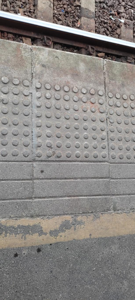

In [ ]:
idx = random.randrange(0, len(val_imgs))
img_path = val_imgs[idx]

pred_caption = generate_caption(img_path)
print('Predicted Caption:', pred_caption)
print()
print(img_path)

# Call the function to display the resized image
display_resized_image(img_path)


testing call function of model

In [ ]:
img_path

'/content/data/Images/Copy_of_IMG_20231013_165939.jpg'

In [ ]:
img = load_image_from_path(img_path)

In [ ]:
caption_model(img)

<tf.Tensor: shape=(), dtype=string, numpy=b'exercise caution you are close to the yellow safety linebe careful'>

In [ ]:
tf.executing_eagerly()

True

In [ ]:
# img = Image.open('/content/data/Images/Copy_of_20231102_153533.jpg')

# # Display the image
# display(img)


grouping the 5 captions with the associated image

In [ ]:
# Initialize an empty dictionary to store image paths and their associated captions
val_image_caption_dict = {}

# Iterate over each image path and caption
for img_path, caption in zip(val_imgs, val_captions):
    # Check if the image path already exists in the dictionary
    if img_path in val_image_caption_dict:
        # If the image path exists, append the caption to its associated list
        val_image_caption_dict[img_path].append(caption)
    else:
        # If the image path does not exist, create a new list with the caption and assign it to the image path key
        val_image_caption_dict[img_path] = [caption]

generating captions using validation dataset images

In [ ]:
generated_captions_dict = {}

for img_path in val_image_caption_dict.keys():
    generated_caption = generate_caption(img_path)
    generated_captions_dict[img_path] = generated_caption

print(generated_captions_dict)

{'/content/data/Images/Copy_of_IMG_20231013_165939.jpg': 'exercise caution you are close to the yellow safety linebe careful', '/content/data/Images/Copy_of_IMG_20231027_164533601.jpg': 'exercise care platform edge is visible ahead be mindful', '/content/data/Images/Copy_of_IMG_20231027_164512274.jpg': 'the stairs on the railway bridge are unoccupied devoid of any people', '/content/data/Images/Copy_of_20231102_155627.jpg': 'the platforms edge is unoccupied presenting a calm and empty view', '/content/data/Images/Copy_of_20231102_154332.jpg': 'people standing inside divyangjan compartment of a train', '/content/data/Images/Copy_of_20231102_155447.jpg': 'on the platform individuals are present with a visible', '/content/data/Images/Copy_of_20231102_155416.jpg': 'people walking on the platform with a divyangjan signboard displayed above', '/content/data/Images/Copy_of_20231102_153913.jpg': 'the stairs on the railway bridge are unoccupied devoid of people', '/content/data/Images/Copy_of_I

## BLEU score

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

# Initialize a list to store BLEU scores for each image
image_bleu_scores = []

# Iterate over each image path and its associated captions in the dictionary
for img_path, captions in val_image_caption_dict.items():
    bleu_scores_per_image = []  # Initialize a list to store BLEU scores for this image

    # Generate caption for the image using your model (replace with your actual function)
    predicted_caption = generated_captions_dict[img_path]

    # Iterate over each ground truth caption for the current image
    for ground_truth_caption in captions:
        # Compute BLEU score for the predicted caption and the current ground truth caption
        bleu = sentence_bleu([ground_truth_caption], predicted_caption)
        bleu_scores_per_image.append(bleu)  # Store BLEU score for this ground truth caption

    # Calculate average BLEU score for this image
    average_bleu_per_image = sum(bleu_scores_per_image) / len(bleu_scores_per_image)

    # Save the average BLEU score for this image
    image_bleu_scores.append(average_bleu_per_image)

# Calculate average BLEU score across all images
average_bleu_across_images = sum(image_bleu_scores) / len(image_bleu_scores)
print("Average BLEU score across all images:", average_bleu_across_images)

Average BLEU score across all images: 0.39221226131772907


BLEU score - Ensemble Evaluation

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

# Initialize a list to store maximum BLEU scores for each image
max_bleu_scores = []

# Iterate over each image path and its associated captions in the dictionary
for img_path, gt_captions in val_image_caption_dict.items():
    max_bleu_score = 0  # Initialize maximum BLEU score for the current image

    # Get the generated caption for the current image
    pred_caption = generated_captions_dict[img_path]

    # Iterate over each ground truth caption for the current image
    for ground_truth_caption in gt_captions:
        # Compute BLEU score for the generated caption and the current ground truth caption
        bleu = sentence_bleu([ground_truth_caption], pred_caption)
        # Update the maximum BLEU score if the current BLEU score is higher
        max_bleu_score = max(max_bleu_score, bleu)
        print("Bleu score for caption: ", bleu)
    print("-----max bleu score: ", max_bleu_score)
    print()

    # Save the maximum BLEU score for the current image
    max_bleu_scores.append(max_bleu_score)

# Calculate average maximum BLEU score
average_max_bleu = sum(max_bleu_scores) / len(max_bleu_scores)
print("Average maximum BLEU score:", average_max_bleu)


Bleu score for caption:  0.19413633887611165
Bleu score for caption:  0.31577761858970177
Bleu score for caption:  0.20634766536545154
Bleu score for caption:  0.19202814005346325
Bleu score for caption:  0.3170169133392747
-----max bleu score:  0.3170169133392747

Bleu score for caption:  0.44634275164588255
Bleu score for caption:  0.46388385696401646
Bleu score for caption:  0.5219211840416476
Bleu score for caption:  0.42387709372555316
Bleu score for caption:  0.3364066344937241
-----max bleu score:  0.5219211840416476

Bleu score for caption:  0.3683595511939213
Bleu score for caption:  0.3562503721938768
Bleu score for caption:  0.37614441976473845
Bleu score for caption:  0.3431860330167427
Bleu score for caption:  0.3240797813982821
-----max bleu score:  0.37614441976473845

Bleu score for caption:  0.2917600533164136
Bleu score for caption:  0.25513875887562043
Bleu score for caption:  0.2657341048138223
Bleu score for caption:  0.24148451452499733
Bleu score for caption:  0.

## CIDEr Score

In [ ]:
pip install pycocoevalcap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 9.9 MB/s eta 0:00:00


Converting the generated captions to a list format for cider

In [ ]:
formatted_generated_captions_dict = {k: [v] for k, v in generated_captions_dict.items()}

print(formatted_generated_captions_dict)

{'/content/data/Images/Copy_of_IMG_20231013_165939.jpg': ['exercise caution you are close to the yellow safety linebe careful'], '/content/data/Images/Copy_of_IMG_20231027_164533601.jpg': ['exercise care platform edge is visible ahead be mindful'], '/content/data/Images/Copy_of_IMG_20231027_164512274.jpg': ['the stairs on the railway bridge are unoccupied devoid of any people'], '/content/data/Images/Copy_of_20231102_155627.jpg': ['the platforms edge is unoccupied presenting a calm and empty view'], '/content/data/Images/Copy_of_20231102_154332.jpg': ['people standing inside divyangjan compartment of a train'], '/content/data/Images/Copy_of_20231102_155447.jpg': ['on the platform individuals are present with a visible'], '/content/data/Images/Copy_of_20231102_155416.jpg': ['people walking on the platform with a divyangjan signboard displayed above'], '/content/data/Images/Copy_of_20231102_153913.jpg': ['the stairs on the railway bridge are unoccupied devoid of people'], '/content/data/

In [ ]:
from pycocoevalcap.cider.cider import Cider

# Initialize a CIDEr scorer
cider_scorer = Cider()

# Compute the CIDEr score
cider_score, _ = cider_scorer.compute_score(gts=val_image_caption_dict, res=formatted_generated_captions_dict)

print("CIDEr score:", cider_score)


CIDEr score: 1.0462949887418447


In [ ]:
# res = {
#     "image1": [["this is an image"], ["this is a"]]
# }

# gt = {
#     "image1": ["this is a image"]
# }

# cider_score, _ = cider_scorer.compute_score(res, gt)

# print("CIDEr score:", cider_score)

# Saving the model

In [ ]:
# caption_model.save_weights('image_captioning_transformer_weights.h5')

# if not load_weights:
#     from google.colab import drive
#     drive.mount('/content/drive')

# with open('/content/drive/MyDrive/Saved Models/ImageCaptioning/image_captioning_transformer_weights.h5', 'wb') as f:
#     f.write(open('image_captioning_transformer_weights.h5', 'rb').read())

to save the model weights

In [ ]:
# Assuming `caption_model` is your model
caption_model.save_weights("image_captioning_transformer_weights.h5")

to download the model weights

In [ ]:
# from google.colab import files

# files.download('image_captioning_transformer_weights.h5')

to save architecture and convert to .tflite

In [ ]:
# Assuming 'caption_model' is your ImageCaptioningModel instance
for i, input_layer in enumerate(caption_model.layers):
    if isinstance(input_layer, tf.keras.layers.InputLayer):
        input_shape = input_layer.input_shape[1:]
        print(f"Input shape of input layer {i + 1}: {input_shape}")


In [ ]:
# # Instantiate the model with the same architecture
# loaded_model = ImageCaptioningModel(
#     cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation
# )

# # Call the model with dummy input to build its internal components
# _ = loaded_model(dummy_input)

# # Load the saved weights into the loaded model
# loaded_model.load_weights(weights_path)


In [ ]:
# # Convert the model to TensorFlow Lite format
# converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
# tflite_model = converter.convert()

# # Save the TensorFlow Lite model to a file
# tflite_path = "/content/caption_model.tflite"
# with open(tflite_path, "wb") as f:
#     f.write(tflite_model)

# print(f"TensorFlow Lite model saved to: {tflite_path}")


# Model Description

In [ ]:
caption_model.summary()

Model: "image_captioning_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, None, 2048)        21802784  
                                                                 
 transformer_encoder_layer   multiple                  2104832   
 (TransformerEncoderLayer)                                       
                                                                 
 transformer_decoder_layer   multiple                  17677630  
 (TransformerDecoderLayer)                                       
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 eager_idx2_word (EagerIdx2  multiple                  0 (unused)
 Word)                                                           
                                            

In [ ]:
model_type = type(caption_model).__name__
print(f"Model type: {model_type}")

Model type: ImageCaptioningModel


# testing to save the model

In [ ]:
while True:
  pass

In [ ]:
# Assuming 'caption_model' is your ImageCaptioningModel instance
caption_model.save("caption_model.h5")

In [ ]:
caption_model.save("caption_model", save_format="tf")